# Data

In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('../full_portfolio_analysis.ipynb'), '..'))
os.chdir(root_dir)
sys.path.insert(0, os.path.join(root_dir, 'src'))

In [2]:

from backbone.utils.wfo_utils import run_strategy, run_wfo
from backbone.utils.general_purpose import calculate_units_size, diff_pips

import itertools
import numpy as np
import pandas as pd
import pandas_ta as pandas_ta
import MetaTrader5 as mt5
import pandas as pd
from backtest.get_data import get_data
import pytz
from datetime import datetime
from pandas import Timestamp
import numpy as np
import random
from backtesting import Strategy
from backtesting.lib import crossover
import talib as ta

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

random.seed(42)

In [3]:
INITIAL_CASH = 10_000
MARGIN = 1/30
COMMISSION = 0.002

timezone = pytz.timezone("Etc/UTC")
date_from_get_data = datetime(2021, 10, 1, tzinfo=timezone)
date_to_get_data = datetime(2024, 9, 1, tzinfo=timezone)

#
limited_testing_start_date = Timestamp('2024-01-01 00:00:00', tz='UTC')
limited_testing_end_date = Timestamp('2024-09-01 00:00:00', tz='UTC')

In [4]:
groups = [
    'Forex',
    'Cash CFD',
    'Cash II CFD',
    'Metals CFD',
    'Crypto CFD',
    'Exotics',
    'Equities I CFD',
    'Equities II CFD',
    'Agriculture',
    'Commodities'
]

In [5]:
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

symbols = mt5.symbols_get()

tickers = [symbol.path.split('\\')[1] for symbol in symbols if (
    ('Agriculture' in symbol.path)
    or ('Cash CFD' in symbol.path)
    or ('Cash II CFD' in symbol.path)
    or ('Crypto CFD' in symbol.path)
    or ('Equities I CFD' in symbol.path)
    or ('Equities II CFD' in symbol.path)
    or ('Agriculture' in symbol.path)
    or ('Equities II CFD' in symbol.path)
    or ('Commodities' in symbol.path)
    or ('Forex' in symbol.path)
    )
]


print(tickers)

intervals = [
    # mt5.TIMEFRAME_H8,
    # mt5.TIMEFRAME_H6,
    mt5.TIMEFRAME_H4,
    mt5.TIMEFRAME_H3,
    mt5.TIMEFRAME_H2,
    # mt5.TIMEFRAME_H1,
    # mt5.TIMEFRAME_M15,
]

symbols = get_data(tickers, intervals, date_from_get_data, date_to_get_data)

['EURUSD', 'GBPUSD', 'USDCHF', 'USDJPY', 'USDCAD', 'AUDUSD', 'AUDNZD', 'AUDCAD', 'AUDCHF', 'AUDJPY', 'CHFJPY', 'EURGBP', 'EURAUD', 'EURCHF', 'EURJPY', 'EURNZD', 'EURCAD', 'GBPCHF', 'GBPJPY', 'CADCHF', 'CADJPY', 'GBPAUD', 'GBPCAD', 'GBPNZD', 'NZDCAD', 'NZDCHF', 'NZDJPY', 'NZDUSD', 'GER40.cash', 'UK100.cash', 'US100.cash', 'US30.cash', 'US500.cash', 'AUS200.cash', 'EU50.cash', 'FRA40.cash', 'HK50.cash', 'JP225.cash', 'N25.cash', 'SPN35.cash', 'US2000.cash', 'UKOIL.cash', 'USOIL.cash', 'ADAUSD', 'BTCUSD', 'DASHUSD', 'DOGEUSD', 'DOTUSD', 'ETHUSD', 'LTCUSD', 'NEOUSD', 'XMRUSD', 'XRPUSD', 'AAPL', 'AMZN', 'BABA', 'BAC', 'GOOG', 'MSFT', 'NFLX', 'NVDA', 'PFE', 'RACE', 'T', 'TSLA', 'V', 'WMT', 'ZM', 'AIRF', 'ALVG', 'BAYGn', 'DBKGn', 'IBE', 'LVMH', 'VOWG_p', 'META', 'COCOA.c', 'COFFEE.c', 'CORN.c', 'SOYBEAN.c', 'WHEAT.c', 'NATGAS.cash']
MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4288
EURUSD
EURUSD
EURUSD
GBPUSD
GBPUSD
GBPUSD
USDCHF
USDCHF
USDCHF
USDJPY
USDJPY
U

In [6]:
max_start_date = None
intervals_start_dates = {}

tickers = np.unique(list(symbols.keys())).tolist()

for interval in intervals:
    for ticker in tickers:
        if not max_start_date or symbols[ticker][interval].index.min() > max_start_date:
            max_start_date = symbols[ticker][interval].index.min()
        
    intervals_start_dates[interval] = max_start_date


print(intervals_start_dates)
print(limited_testing_start_date)
print(limited_testing_end_date)

{16388: Timestamp('2024-10-23 00:00:00+0000', tz='UTC'), 16387: Timestamp('2024-10-23 00:00:00+0000', tz='UTC'), 16386: Timestamp('2024-10-23 00:00:00+0000', tz='UTC')}
2024-01-01 00:00:00+00:00
2024-09-01 00:00:00+00:00


In [ ]:

from backbone.dema_supertrend import DemaSuperTrend


STRATEGY = DemaSuperTrend

# Analisis preliminar

In [ ]:
strategies = [
    STRATEGY
]

experiments = list(itertools.product(
    tickers, intervals, strategies
))

stats_per_symbol = {}

performance = pd.DataFrame()

for ticker, interval, strategy in experiments:
    try:
        print(ticker, interval)
        
        if ticker not in stats_per_symbol.keys():
            stats_per_symbol[ticker] = {}
        
        prices = symbols[ticker][interval].loc[limited_testing_start_date:limited_testing_end_date]

        df_stats, stats = run_strategy(
            strategy=strategy,
            ticker=ticker,
            interval=interval,
            commission=COMMISSION, 
            prices=prices, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN
        )

        performance = pd.concat([performance, df_stats])
        stats_per_symbol[ticker][interval] = stats

    except Exception as e:
        print(f'hubo un problema con {ticker} {interval}: {e}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)

AAPL 16388
AAPL 16387
AAPL 16386
ADAUSD 16388
ADAUSD 16387
ADAUSD 16386
AIRF 16388
AIRF 16387
AIRF 16386
ALVG 16388
ALVG 16387
ALVG 16386
AMZN 16388
AMZN 16387
AMZN 16386
AUDCAD 16388
AUDCAD 16387
AUDCAD 16386
AUDCHF 16388
AUDCHF 16387
AUDCHF 16386
AUDJPY 16388
AUDJPY 16387
AUDJPY 16386
AUDNZD 16388
AUDNZD 16387
AUDNZD 16386
AUDUSD 16388
AUDUSD 16387
AUDUSD 16386
AUS200.cash 16388
AUS200.cash 16387
AUS200.cash 16386
BABA 16388
BABA 16387
BABA 16386
BAC 16388
BAC 16387
BAC 16386
BAYGn 16388
BAYGn 16387
BAYGn 16386
BTCUSD 16388
BTCUSD 16387
BTCUSD 16386
CADCHF 16388
CADCHF 16387
CADCHF 16386
CADJPY 16388
CADJPY 16387
CADJPY 16386
CHFJPY 16388
CHFJPY 16387
CHFJPY 16386
COCOA.c 16388
COCOA.c 16387
COCOA.c 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


COFFEE.c 16388
COFFEE.c 16387
COFFEE.c 16386
CORN.c 16388
CORN.c 16387
CORN.c 16386
DASHUSD 16388
DASHUSD 16387
DASHUSD 16386
DBKGn 16388
DBKGn 16387
DBKGn 16386
DOGEUSD 16388
DOGEUSD 16387
DOGEUSD 16386
DOTUSD 16388
DOTUSD 16387
DOTUSD 16386
ETHUSD 16388
ETHUSD 16387
ETHUSD 16386
EU50.cash 16388
EU50.cash 16387
EU50.cash 16386
EURAUD 16388
EURAUD 16387
EURAUD 16386
EURCAD 16388
EURCAD 16387
EURCAD 16386
EURCHF 16388
EURCHF 16387
EURCHF 16386
EURGBP 16388
EURGBP 16387
EURGBP 16386
EURJPY 16388
EURJPY 16387
EURJPY 16386
EURNZD 16388
EURNZD 16387
EURNZD 16386
EURUSD 16388
EURUSD 16387
EURUSD 16386
FRA40.cash 16388
FRA40.cash 16387
FRA40.cash 16386
GBPAUD 16388
GBPAUD 16387
GBPAUD 16386
GBPCAD 16388
GBPCAD 16387
GBPCAD 16386
GBPCHF 16388
GBPCHF 16387
GBPCHF 16386
GBPJPY 16388
GBPJPY 16387
GBPJPY 16386
GBPNZD 16388
GBPNZD 16387
GBPNZD 16386
GBPUSD 16388
GBPUSD 16387
GBPUSD 16386
GER40.cash 16388
GER40.cash 16387
GER40.cash 16386
GOOG 16388
GOOG 16387
GOOG 16386
HK50.cash 16388
HK50.cash 16

In [11]:

filter_performance = performance[
    (performance['return/dd']>=2)
    & (performance['trades']>1)
].sort_values(by=['return/dd'], ascending=[False]).drop_duplicates(subset=['ticker'], keep='first')

portfolio = filter_performance.ticker.tolist()
intervals = filter_performance.interval.values.tolist()

filter_performance


,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,DemaSuperTrend,AIRF,16387,0.615042,8.755969,10875.596883,2.523733,20 days 00:00:00,60.000000,1.520742,5,3.544361,33.040936,10875.596883,241 days 09:00:00,3.469451,4.452264
0,DemaSuperTrend,SOYBEAN.c,16387,0.623238,12.888936,11288.893576,4.897838,45 days 18:00:00,40.000000,1.400941,10,0.894300,33.476027,11288.893576,241 days 06:00:00,2.631556,5.240279
0,DemaSuperTrend,AUDJPY,16388,0.213347,74.328848,17432.884801,30.146554,104 days 08:00:00,40.000000,1.066049,10,0.644738,20.019157,17432.884801,241 days 20:00:00,2.465584,5.722392
0,DemaSuperTrend,EURCHF,16388,0.554278,9.275523,10927.552315,3.837835,72 days 20:00:00,33.333333,1.277897,3,0.603334,15.900383,10927.552315,241 days 20:00:00,2.416863,2.657925


In [12]:
filter_performance = performance[performance['ticker'].isin(portfolio)].sort_values(by=['ticker', 'interval'], ascending=[False, True])[
    [
        'strategy',
        'ticker',
        'interval',
        'stability_ratio',
        'trades',
        'return',
        'drawdown',
        'return/dd',
        'custom_metric'
        ]
]#.drop_duplicates(subset=['ticker'], keep='first')

portfolio = filter_performance.ticker.tolist()
intervals = filter_performance.interval.values.tolist()

display(filter_performance.tail(50))

pd.DataFrame(filter_performance.groupby(['strategy','ticker'])['return/dd'].mean()).sort_values(by='return/dd')

,strategy,ticker,interval,stability_ratio,trades,return,drawdown,return/dd,custom_metric
0,DemaSuperTrend,SOYBEAN.c,16386,0.187823,22,-6.444649,14.133550,-0.455982,-1.335256
0,DemaSuperTrend,SOYBEAN.c,16387,0.623238,10,12.888936,4.897838,2.631556,5.240279
0,DemaSuperTrend,SOYBEAN.c,16388,0.603102,8,10.865061,4.410471,2.463470,4.412367
0,DemaSuperTrend,EURCHF,16386,0.297014,17,17.528820,13.885499,1.262383,3.403635
0,DemaSuperTrend,EURCHF,16387,0.884375,11,-12.517608,12.517608,-1.000000,-2.301079
0,DemaSuperTrend,EURCHF,16388,0.554278,3,9.275523,3.837835,2.416863,2.657925
0,DemaSuperTrend,AUDJPY,16386,0.017854,17,37.556650,52.074221,0.721214,2.045300
0,DemaSuperTrend,AUDJPY,16387,0.129047,11,60.279863,38.841468,1.551946,3.759646
0,DemaSuperTrend,AUDJPY,16388,0.213347,10,74.328848,30.146554,2.465584,5.722392
0,DemaSuperTrend,AIRF,16386,0.634323,8,7.597676,3.757868,2.021805,3.508672


return/dd
strategy       ticker              
DemaSuperTrend EURCHF      0.893082
               SOYBEAN.c   1.546348
               AUDJPY      1.579581
               AIRF        1.702130

In [13]:

filter_performance = performance[
    (performance['ticker'] == 'ZM')
    | (performance['ticker'] == 'DOGEUSD')
    | (performance['ticker'] == 'ETHUSD')
    | (performance['ticker'] == 'TSLA')
    | (performance['ticker'] == 'AUDJPY')
    | (performance['ticker'] == 'SOYBEAN.c')
    | (performance['ticker'] == 'ADAUSD')
    | (performance['ticker'] == 'AIRF')
    | (performance['ticker'] == 'EURCHF')
].sort_values(by=['return/dd'], ascending=[False])

portfolio = filter_performance.ticker.tolist()
intervals = filter_performance.interval.values.tolist()

filter_performance

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,DemaSuperTrend,ZM,16387,0.134331,7.829578,10782.957760,0.771100,4 days 00:00:00,100.000000,1.411563,1,15.687134,3.180915,10782.957760,241 days 06:00:00,10.153777,3.064225
0,DemaSuperTrend,AIRF,16387,0.615042,8.755969,10875.596883,2.523733,20 days 00:00:00,60.000000,1.520742,5,3.544361,33.040936,10875.596883,241 days 09:00:00,3.469451,4.452264
0,DemaSuperTrend,SOYBEAN.c,16387,0.623238,12.888936,11288.893576,4.897838,45 days 18:00:00,40.000000,1.400941,10,0.894300,33.476027,11288.893576,241 days 06:00:00,2.631556,5.240279
0,DemaSuperTrend,AUDJPY,16388,0.213347,74.328848,17432.884801,30.146554,104 days 08:00:00,40.000000,1.066049,10,0.644738,20.019157,17432.884801,241 days 20:00:00,2.465584,5.722392
0,DemaSuperTrend,SOYBEAN.c,16388,0.603102,10.865061,11086.506134,4.410471,47 days 08:00:00,50.000000,1.369107,8,1.104900,31.631632,11086.506134,241 days 04:00:00,2.463470,4.412367
0,DemaSuperTrend,EURCHF,16388,0.554278,9.275523,10927.552315,3.837835,72 days 20:00:00,33.333333,1.277897,3,0.603334,15.900383,10927.552315,241 days 20:00:00,2.416863,2.657925
0,DemaSuperTrend,AIRF,16386,0.634323,7.597676,10759.767594,3.757868,45 days 04:00:00,37.500000,1.269430,8,1.807564,24.561404,10759.767594,241 days 08:00:00,2.021805,3.508672
0,DemaSuperTrend,ADAUSD,16387,0.794608,12.842895,11284.289482,6.652435,111 days 03:00:00,50.000000,1.139928,18,1.592236,33.876050,11284.289482,244 days 00:00:00,1.930556,4.941580
0,DemaSuperTrend,DOGEUSD,16387,0.619987,18.825642,11882.564217,11.212614,115 days 21:00:00,38.461538,1.261889,13,1.608975,23.581933,11882.564217,244 days 00:00:00,1.678970,4.068085
0,DemaSuperTrend,AUDJPY,16387,0.129047,60.279863,16027.986258,38.841468,109 days 18:00:00,18.181818,0.883576,11,0.467845,21.120690,16027.986258,241 days 21:00:00,1.551946,3.759646


In [14]:
for ticker, interval in zip(portfolio, intervals):
    
    prices = symbols[ticker][interval].loc[limited_testing_start_date:limited_testing_end_date]

    df_stats = run_strategy(
        strategy=strategy,
        ticker=ticker,
        interval=interval,
        commission=COMMISSION, 
        prices=prices, 
        initial_cash=INITIAL_CASH, 
        margin=MARGIN,
        plot=True
    )

    break

c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


# WFO

In [15]:
lookback_bars_per_interval = {
    15: 2000,
    16385: 2000,
    16386: 1800,
    16387: 1800,
    16388: 1200,
    16390: 1200,
    16392: 1200,
}

In [16]:
from backbone.utils.wfo_utils import optimization_function

validation_bars = 200
warmup_bars = 50

all_wfo_performances = pd.DataFrame()
all_opt_params = {}

params = {
    'supertrend_length': [2, 3, 4, 5],
    'supertrend_multiplier': [2, 3, 4, 5],
    'exit_method' : ['bbands','super_trend'],
}

for index, row in filter_performance.iterrows():
    
    try:
        ticker = row.ticker
        interval = row.interval
        print(ticker, interval)
        
        lookback_bars = lookback_bars_per_interval[interval]
        
        prices = symbols[ticker][interval]

        wfo_stats, df_stats, opt_params = run_wfo(
            strategy=STRATEGY,
            ticker=ticker,
            interval=interval,
            prices=prices,
            initial_cash=INITIAL_CASH,
            commission=COMMISSION,
            margin=MARGIN,
            optim_func=optimization_function,
            params=params,
            lookback_bars=lookback_bars,
            warmup_bars=warmup_bars,
            validation_bars=validation_bars,
            plot=False
        )
                
        if ticker not in all_opt_params.keys():
            all_opt_params[ticker] = {}

        all_opt_params[ticker][interval] = opt_params

        all_wfo_performances = pd.concat([all_wfo_performances, df_stats])
    
    except Exception as e:
        print(f'No se pudo ejecutar para el ticker {ticker}: {e}')
    
all_wfo_performances['return/dd'] = all_wfo_performances['return'] / -all_wfo_performances['drawdown']
all_wfo_performances['drawdown'] = -all_wfo_performances['drawdown']
all_wfo_performances['custom_metric'] = (all_wfo_performances['return'] / (1 + all_wfo_performances.drawdown)) * np.log(1 + all_wfo_performances.trades)

all_wfo_performances.drawdown_duration = pd.to_timedelta(all_wfo_performances.drawdown_duration)
all_wfo_performances.drawdown_duration = all_wfo_performances.drawdown_duration.dt.days

ZM 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


AIRF 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


SOYBEAN.c 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


AUDJPY 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


SOYBEAN.c 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


EURCHF 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


AIRF 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


ADAUSD 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


DOGEUSD 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


AUDJPY 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


ADAUSD 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


EURCHF 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


DOGEUSD 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


AUDJPY 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


ETHUSD 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


ETHUSD 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


ZM 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


ADAUSD 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


ETHUSD 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


TSLA 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


AIRF 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


DOGEUSD 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


SOYBEAN.c 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


TSLA 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


EURCHF 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


TSLA 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


ZM 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\pandas\core\arrays\timedeltas.py:970: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\pandas\core\arrays\timedeltas.py:974: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


In [34]:

performance = pd.DataFrame()

wfo_stats_per_symbol = {}

for index, row in filter_performance.iterrows():
    try:
        ticker = row.ticker
        interval = row.interval
        print(ticker, interval)
        
        prices = symbols[ticker][interval]
        params = all_opt_params[ticker][interval]
        
        if ticker not in wfo_stats_per_symbol.keys():
            wfo_stats_per_symbol[ticker] = {}

        df_stats, wfo_stats = run_strategy(
            strategy=strategy,
            ticker=ticker,
            interval=interval,
            commission=COMMISSION, 
            prices=prices, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN, 
            opt_params=params, 
            plot=False
        )

        wfo_stats_per_symbol[ticker][interval] = wfo_stats

        performance = pd.concat([performance, df_stats])

    except Exception as e:
        print(f'hubo un problema con {ticker} {interval}: {e}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)

ZM 16387
AIRF 16387
SOYBEAN.c 16387
AUDJPY 16388
SOYBEAN.c 16388
EURCHF 16388
AIRF 16386
ADAUSD 16387
DOGEUSD 16387
AUDJPY 16387
ADAUSD 16388
EURCHF 16386
DOGEUSD 16386
AUDJPY 16386
ETHUSD 16387
ETHUSD 16386
ZM 16386
ADAUSD 16386
ETHUSD 16388
TSLA 16386
AIRF 16388
DOGEUSD 16388
SOYBEAN.c 16386
TSLA 16387
EURCHF 16387
TSLA 16388
ZM 16388


In [77]:
display(performance.sort_values(by=['ticker'], ascending=[False])[
    [
        'strategy',
        'ticker',
        'interval',
        'stability_ratio',
        'trades',
        'return',
        'drawdown',
        'return/dd',
        'custom_metric',
        'Duration'
        ]
])

pd.DataFrame(performance.groupby(['ticker'])['return/dd'].mean()).sort_values(by='return/dd')


,strategy,ticker,interval,stability_ratio,trades,return,drawdown,return/dd,custom_metric,Duration
0,DemaSuperTrend,ZM,16387,0.927255,37,-7.570860,16.397396,-0.461711,-1.582976,1064 days 06:00:00
0,DemaSuperTrend,ZM,16386,0.904945,46,-17.265456,21.793974,-0.792212,-2.916321,1064 days 06:00:00
0,DemaSuperTrend,ZM,16388,0.746389,19,-0.837393,6.526177,-0.128313,-0.333318,1064 days 04:00:00
0,DemaSuperTrend,TSLA,16388,0.293851,13,12.120059,9.613400,1.260746,3.013693,1064 days 04:00:00
0,DemaSuperTrend,TSLA,16387,0.826581,16,19.081331,9.831111,1.940913,4.991315,1064 days 06:00:00
0,DemaSuperTrend,TSLA,16386,0.780456,39,31.216698,6.972865,4.476882,14.443319,1064 days 06:00:00
0,DemaSuperTrend,SOYBEAN.c,16386,0.854678,43,-24.958140,25.966140,-0.961180,-3.502405,392 days 04:00:00
0,DemaSuperTrend,SOYBEAN.c,16388,0.691871,15,16.267353,8.062171,2.017738,4.977028,392 days 04:00:00
0,DemaSuperTrend,SOYBEAN.c,16387,0.827329,18,24.971138,7.046176,3.543928,9.138005,392 days 06:00:00
0,DemaSuperTrend,EURCHF,16388,0.642547,51,-18.092379,29.724375,-0.608671,-2.326732,1064 days 20:00:00


,return/dd
ticker,
AUDJPY,-0.914284
EURCHF,-0.834326
AIRF,-0.628828
ZM,-0.460746
ADAUSD,0.542110
DOGEUSD,0.593425
ETHUSD,1.260810
SOYBEAN.c,1.533495
TSLA,2.559514


In [78]:
filtered_wfo_performance = performance[
    (
        ((performance['ticker'] == 'TSLA') & (performance['interval'] == 16386))
        | ((performance['ticker'] == 'SOYBEAN.c') & (performance['interval'] == 16387))
        | ((performance['ticker'] == 'ETHUSD') & (performance['interval'] == 16387))
    )
].sort_values(by='custom_metric', ascending=False).drop_duplicates(subset=['ticker'], keep='first')

filtered_wfo_performance

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,DemaSuperTrend,TSLA,16386,0.780456,31.216698,13121.669824,6.972865,270 days 00:00:00,38.461538,0.966025,39,1.258734,26.728268,13121.669824,1064 days 06:00:00,4.476882,14.443319
0,DemaSuperTrend,SOYBEAN.c,16387,0.827329,24.971138,12497.113817,7.046176,104 days 15:00:00,50.000000,1.499681,18,0.969916,46.441948,12497.113817,392 days 06:00:00,3.543928,9.138005
0,DemaSuperTrend,ETHUSD,16387,0.420688,43.770440,14377.043960,24.169926,462 days 00:00:00,30.088496,0.674225,113,0.284432,38.412094,14377.043960,1066 days 00:00:00,1.810946,8.236238


# Montecarlo

In [79]:
# Crear una lista para almacenar los resultados de cada ticker
from backbone.utils.montecarlo_utils import montecarlo_statistics_simulation

data_drawdown = []
data_return = []
montecarlo_simulations = {}

all_drawdowns = pd.DataFrame()
all_returns = pd.DataFrame()

for index, row in filtered_wfo_performance.iterrows():
    ticker = row.ticker
    interval = row.interval
    try:
        
        print(f"Procesando ticker: {ticker} {interval}")
        trades_history = wfo_stats_per_symbol[ticker][interval]._trades
        eq_curve = wfo_stats_per_symbol[ticker][interval]._equity_curve
        
        # Simulación de Montecarlo para cada ticker (datos agregados)
        mc, synthetic_drawdown_curve, synthetic_return_curve = montecarlo_statistics_simulation(
            equity_curve=eq_curve,
            trade_history=trades_history, 
            n_simulations=100_000, 
            initial_equity=INITIAL_CASH, 
            threshold_ruin=0.9, 
            return_raw_curves=True,
            percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]
        )
        
        montecarlo_simulations[f"{ticker}_{interval}"] = mc
        
        synthetic_drawdown_curve["ticker"] = f"{ticker}_{interval}"
        synthetic_return_curve["ticker"] = f"{ticker}_{interval}"
        
        all_drawdowns = pd.concat([all_drawdowns, synthetic_drawdown_curve])
        all_returns = pd.concat([all_returns, synthetic_return_curve])
    
    except Exception as e:
        print(f'hubo un problema con {ticker}_{interval}: {e}')

Procesando ticker: TSLA 16386
Procesando ticker: SOYBEAN.c 16387
Procesando ticker: ETHUSD 16387


In [80]:
dd_df = pd.DataFrame()
returns_df = pd.DataFrame()

for ticker, mc in montecarlo_simulations.items():
    mc = mc.rename(
        columns={
            'Drawdown (%)': f'drawdown_{ticker}',
            'Final Return (%)': f'return_{ticker}',
        }
    )

    if dd_df.empty:
        dd_df = mc[[f'drawdown_{ticker}']]
    
    else:
        dd_df = pd.merge(
            dd_df,
            mc[[f'drawdown_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
    if returns_df.empty:
        returns_df = mc[[f'return_{ticker}']]
    
    else:
        returns_df = pd.merge(
            returns_df,
            mc[[f'return_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
display(dd_df)
display(returns_df)


,drawdown_TSLA_16386,drawdown_SOYBEAN.c_16387,drawdown_ETHUSD_16387
count,100000.000000,100000.000000,100000.000000
mean,-13.205147,-8.281893,-32.464246
std,5.815784,4.552937,11.054607
min,-59.668934,-42.200256,-86.963373
10%,-21.118922,-14.340907,-47.897473
25%,-16.253131,-10.560476,-39.190344
50%,-12.067241,-7.385481,-30.799290
75%,-8.982021,-5.036795,-24.176071
90%,-6.890632,-3.416697,-19.590288
max,-1.800746,0.000000,-7.716366


,return_TSLA_16386,return_SOYBEAN.c_16387,return_ETHUSD_16387
count,100000.000000,100000.000000,100000.000000
mean,36.454361,29.564893,58.103914
std,29.873629,21.186567,77.417101
min,-57.956293,-38.511937,-83.730854
10%,1.021144,3.713748,-21.650875
25%,15.314714,14.610996,4.181145
50%,33.292786,27.997532,42.231726
75%,54.267809,42.751029,93.903931
90%,75.816821,57.475834,157.114245
max,224.194644,146.291354,1318.356989


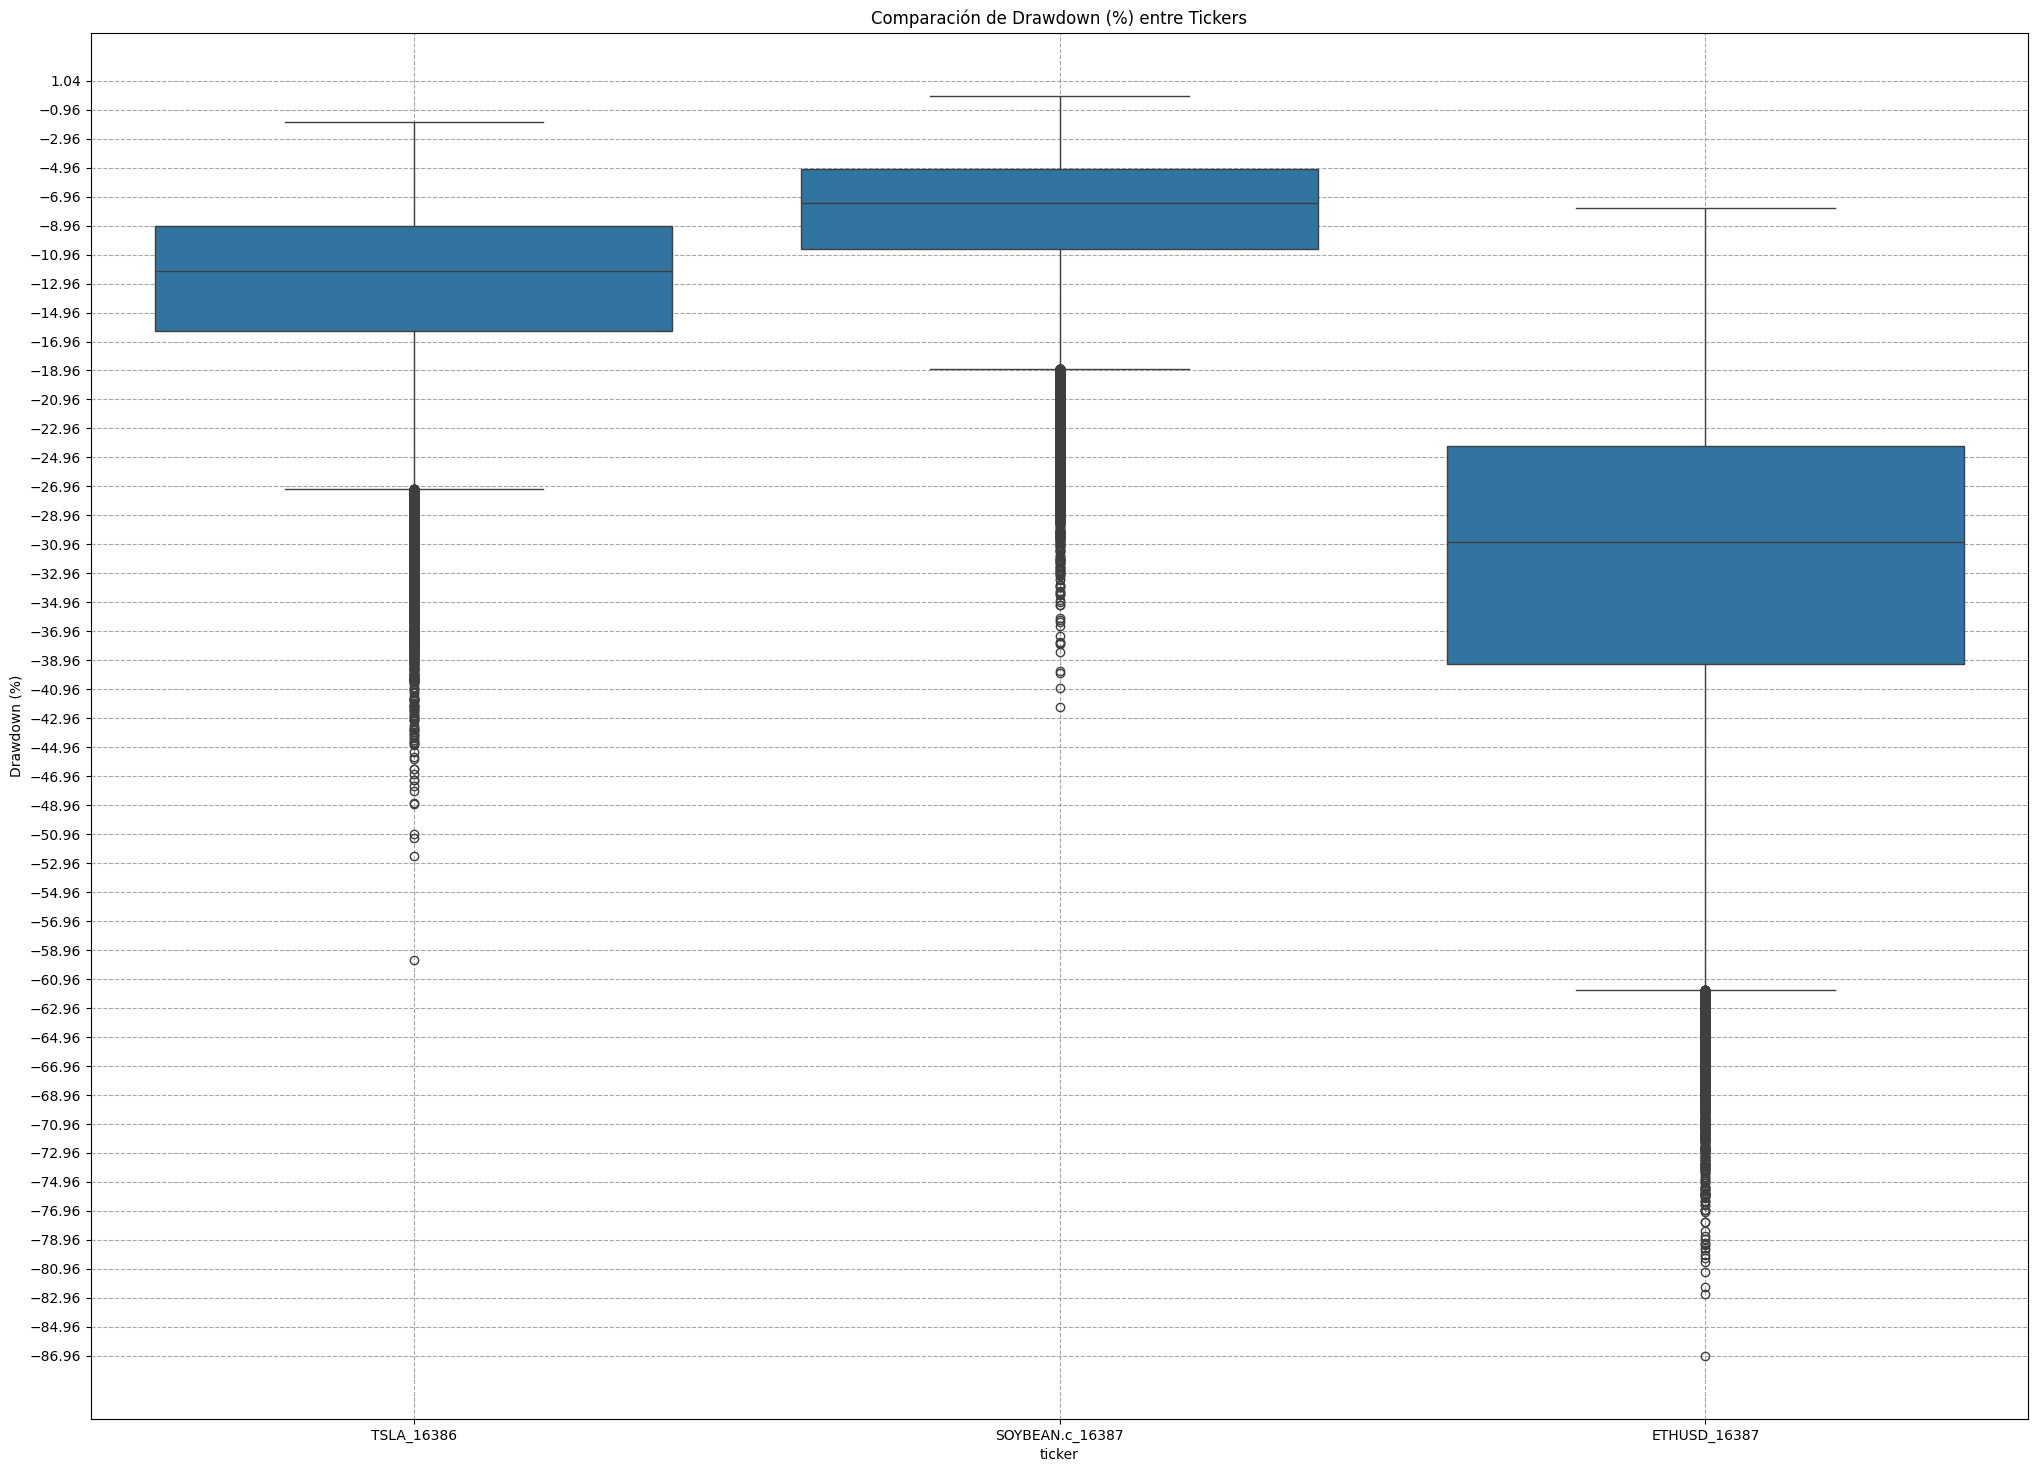

In [81]:
# Configurar el gráfico con matplotlib y seaborn
plt.figure(figsize=(25, 18))
sns.boxplot(data=all_drawdowns, x="ticker", y="Drawdown (%)")
plt.title("Comparación de Drawdown (%) entre Tickers")

y_max = all_drawdowns["Drawdown (%)"].max()  # Valor máximo en el eje Y
y_min = all_drawdowns["Drawdown (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 2  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()


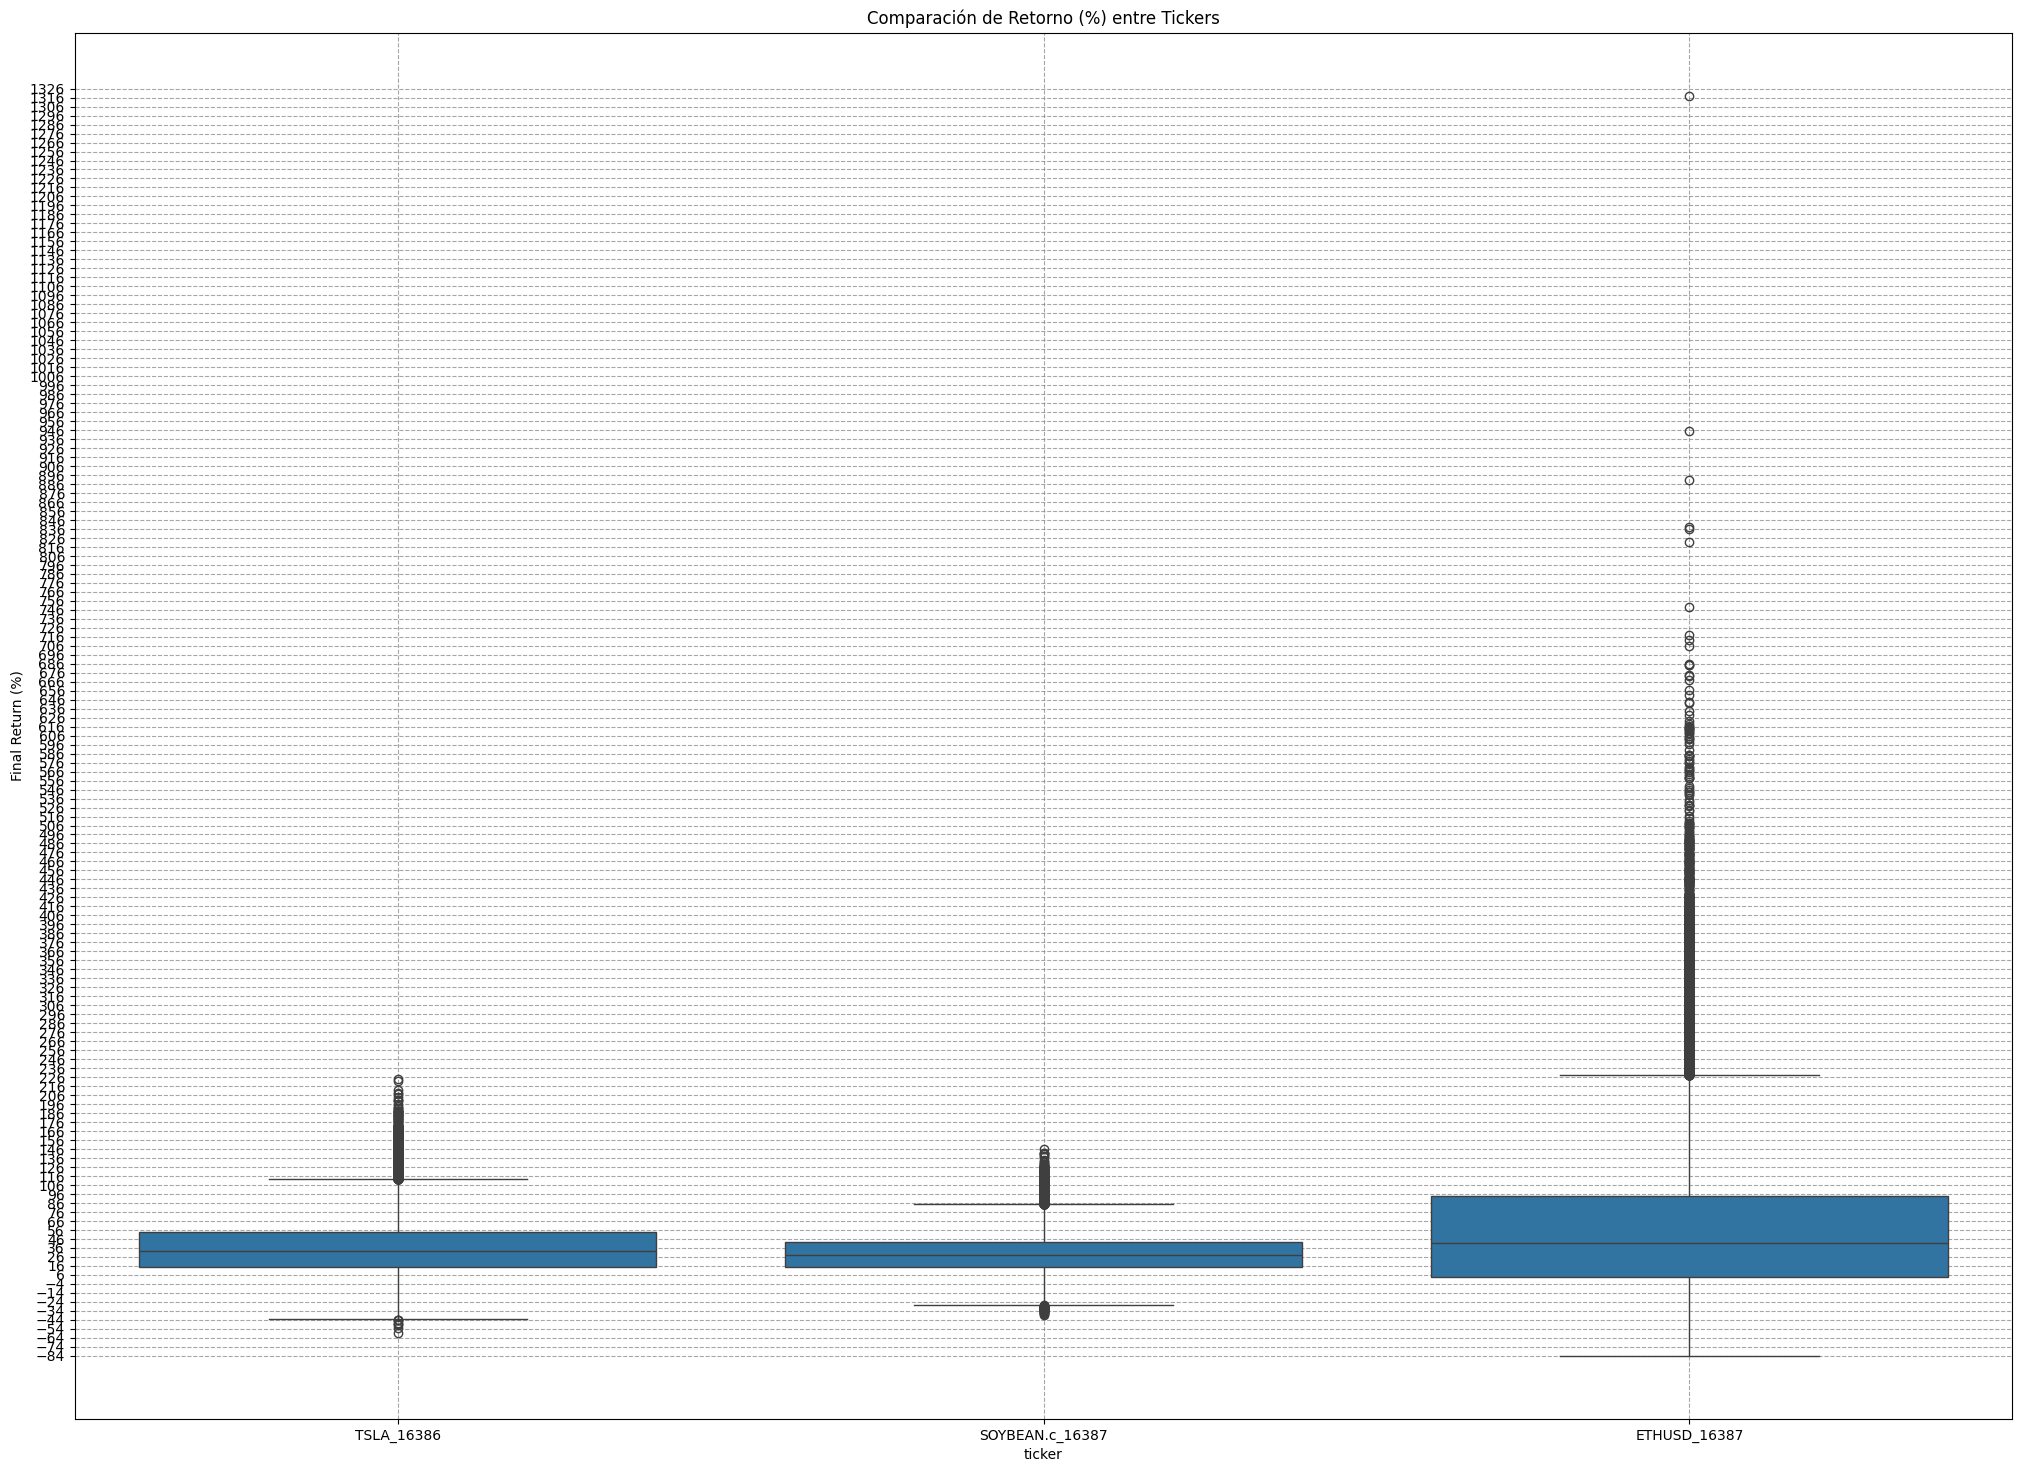

In [82]:
# Generar el gráfico
plt.figure(figsize=(25, 18))
sns.boxplot(data=all_returns, x="ticker", y="Final Return (%)")
plt.title("Comparación de Retorno (%) entre Tickers")

# Configurar ticks mayores con más números
y_max = all_returns["Final Return (%)"].max()  # Valor máximo en el eje Y
y_min = all_returns["Final Return (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 10  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()
